<H1>Testing inhibitory motifs</H1>

In [104]:
# loading python modules
import numpy as np
np.random.seed(0)

from matplotlib.pyplot import figure
from terminaltables import AsciiTable 
import matplotlib.pyplot as plt
%matplotlib inline  

from __future__ import division

In [105]:
# loading custom inet modules
from inet import DataLoader
from inet.motifs import iicounter, motifcounter
from inet.utils import chem_squarematrix, elec_squarematrix

In [106]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data/PV')

 182 syn  files loaded


<H2>Collect number of experiments containing PV(+) cells</H2>

In [107]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.IN[i].values())

In [108]:
for i, experiment in enumerate(nPV):
    print('{:<3d} recordings with {:2d} PV-cells'.format(experiment, i))

0   recordings with  0 PV-cells
149 recordings with  1 PV-cells
26  recordings with  2 PV-cells
7   recordings with  3 PV-cells
0   recordings with  4 PV-cells
0   recordings with  5 PV-cells
0   recordings with  6 PV-cells
0   recordings with  7 PV-cells
0   recordings with  8 PV-cells


In [109]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.IN[2].values())
PV3 = sum(mydataset.IN[3].values())
PV2, PV3

(26, 7)

<H2> Calculate empirical probabilities </H2>

In [110]:
PC = mydataset.motif.ii_chem_found/mydataset.motif.ii_chem_tested
PE = mydataset.motif.ii_elec_found/mydataset.motif.ii_elec_tested

PC2  = mydataset.motif.ii_c2_found/mydataset.motif.ii_c2_tested
Pdiv = mydataset.motif.ii_div_found/mydataset.motif.ii_div_tested
Pcon = mydataset.motif.ii_con_found/mydataset.motif.ii_con_tested
Pchain = mydataset.motif.ii_chain_found/mydataset.motif.ii_chain_tested

PC1E = mydataset.motif.ii_c1e_found/mydataset.motif.ii_c1e_tested
PC2E = mydataset.motif.ii_c2e_found/mydataset.motif.ii_c2e_tested



info = [
    ['key', 'Probability', 'Motif', 'Value'],
    ['ii_chem', 'P(C)', 'chemical synapse',PC ],
    ['ii_elec', 'P(E)', 'electrical synapse',PE ],
    ['','',''],
    ['ii_c2', 'P(C U C)','bidirectional chemical synapse',PC2],
    ['ii_con', 'Pcon', 'convergent inhibitory motifs', Pcon],
    ['ii_div', 'Pdiv', 'divergent inhibitory motifs', Pdiv],
    ['ii_chain', 'Pchain', 'linear inhibitory motifs', Pchain],
    ['',''],
    ['ii_c1e', 'P(C U E)', 'electrical and unidirectional chemical', PC1E],
    ['ii_c2e', 'P(2C U E):','electrical and bidirectional chemical', PC2E],

]
print(AsciiTable(info).table)

+----------+-------------+----------------------------------------+-----------------+
| key      | Probability | Motif                                  | Value           |
+----------+-------------+----------------------------------------+-----------------+
| ii_chem  | P(C)        | chemical synapse                       | 0.276595744681  |
| ii_elec  | P(E)        | electrical synapse                     | 0.468085106383  |
|          |             |                                        |                 |
| ii_c2    | P(C U C)    | bidirectional chemical synapse         | 0.148936170213  |
| ii_con   | Pcon        | convergent inhibitory motifs           | 0.047619047619  |
| ii_div   | Pdiv        | divergent inhibitory motifs            | 0.142857142857  |
| ii_chain | Pchain      | linear inhibitory motifs               | 0.0952380952381 |
|          |             |                                        |                 |
| ii_c1e   | P(C U E)    | electrical and unidirection

<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [111]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [112]:
print(mychem_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 94     |
| ii_c2    | 6     | 47     |
| ii_c2e   | 0     | 47     |
| ii_chain | 8     | 21     |
| ii_chem  | 28    | 94     |
| ii_con   | 5     | 21     |
| ii_div   | 2     | 21     |
| ii_elec  | 0     | 47     |
+----------+-------+--------+



In [113]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])


('ii_chem', {'tested': 94L, 'found': 26})
('ii_c1e', {'tested': 94L, 'found': 17})
('ii_div', {'tested': 21L, 'found': 3})
('ii_c2e', {'tested': 47L, 'found': 6})
('ii_elec', {'tested': 47L, 'found': 22})
('ii_chain', {'tested': 21L, 'found': 2})
('ii_con', {'tested': 21L, 'found': 1})
('ii_c2', {'tested': 47L, 'found': 7})


In [114]:
# simulate the whole data set 1,000 times
n_chem = list()

n_bichem = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found']) # null hypothesis
    
    n_bichem.append(syn_counter['ii_c2']['found'])    
    n_con.append(syn_counter['ii_con']['found'])
    n_div.append(syn_counter['ii_div']['found'])
    n_chain.append(syn_counter['ii_chain']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [115]:
np.mean(n_chem) # on average the same number of unidirectional connections


26.120999999999999

In [116]:
mydataset.motif['ii_chem']['found']

26

If we found a number which is different form the empirical, we must revise our 
null hypothese.

In [117]:
np.mean(n_bichem) # on average the same number of bidirectional connections????

3.6099999999999999

Define analiticaly the null hypothese:

In [118]:
PC*PC*mydataset.motif['ii_c2']['tested'] # null hypothesis

3.5957446808510642

In [119]:
mydataset.motif['ii_c2']['found'] # however, we found more empirically

7

In [120]:
# Number of divergent connections found should be very similar to the ones calculates
np.mean(n_div)

1.587

In [121]:
PC*PC*mydataset.motif['ii_div']['tested'] # null hypothesis

1.6066093254866458

In [122]:
np.mean(n_con)

1.609

In [123]:
PC*PC*mydataset.motif['ii_con']['tested'] # null hypothesis

1.6066093254866458

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [124]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [125]:
print(myelec_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 94     |
| ii_c2    | 0     | 47     |
| ii_c2e   | 0     | 47     |
| ii_chain | 0     | 21     |
| ii_chem  | 0     | 94     |
| ii_con   | 0     | 21     |
| ii_div   | 0     | 21     |
| ii_elec  | 26    | 47     |
+----------+-------+--------+



In [126]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 94L, 'found': 26})
('ii_c1e', {'tested': 94L, 'found': 17})
('ii_div', {'tested': 21L, 'found': 3})
('ii_c2e', {'tested': 47L, 'found': 6})
('ii_elec', {'tested': 47L, 'found': 22})
('ii_chain', {'tested': 21L, 'found': 2})
('ii_con', {'tested': 21L, 'found': 1})
('ii_c2', {'tested': 47L, 'found': 7})


In [127]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [128]:
np.mean(n_elec)

21.963999999999999

In [129]:
mydataset.motif.ii_elec_found # voila!

22

<H2>Simulate electrical and chemical synapses independently</H2>

In [130]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 0],
       [0, 0]])

In [131]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [132]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_c1e': {'found': 14, 'tested': 94L},
 'ii_c2': {'found': 8, 'tested': 47L},
 'ii_c2e': {'found': 5, 'tested': 47L},
 'ii_chain': {'found': 6, 'tested': 21L},
 'ii_chem': {'found': 28, 'tested': 94L},
 'ii_con': {'found': 4, 'tested': 21L},
 'ii_div': {'found': 2, 'tested': 21L},
 'ii_elec': {'found': 24, 'tested': 47L}}

In [133]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 94L, 'found': 26})
('ii_c1e', {'tested': 94L, 'found': 17})
('ii_div', {'tested': 21L, 'found': 3})
('ii_c2e', {'tested': 47L, 'found': 6})
('ii_elec', {'tested': 47L, 'found': 22})
('ii_chain', {'tested': 21L, 'found': 2})
('ii_con', {'tested': 21L, 'found': 1})
('ii_c2', {'tested': 47L, 'found': 7})


In [134]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()

n_c1e = list()
n_c2e = list()

n_c2 = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(1000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] ) # null hypothesis
    n_elec.append( syn_counter['ii_elec']['found'] ) # null hypothesis
    
    n_c1e.append( syn_counter['ii_c1e']['found'] )
    n_c2e.append( syn_counter['ii_c2e']['found'] )
    
    n_c2.append( syn_counter['ii_c2']['found'])
    n_con.append( syn_counter['ii_div']['found'])
    n_div.append( syn_counter['ii_div']['found'])
    n_chain.append( syn_counter['ii_chain']['found'])

In [135]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    [''],
    ['2 chem',np.mean(n_c2),mydataset.motif['ii_c2']['found']],
    ['convergent', np.mean(n_con), mydataset.motif['ii_con']['found']],
    ['divergent', np.mean(n_div), mydataset.motif['ii_div']['found']],
    ['chains', np.mean(n_chain), mydataset.motif['ii_chain']['found']],
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found']],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 26.117      | 26        |
| electrical    | 22.018      | 22        |
|               |             |           |
| 2 chem        | 3.586       | 7         |
| convergent    | 1.635       | 1         |
| divergent     | 1.635       | 3         |
| chains        | 3.274       | 2         |
|               |             |           |
| 1 chem + elec | 12.12       | 17        |
| 2 chem + elec | 1.689       | 6         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>ii_c2: bidirectional chemical connections</H3>

In [136]:
mydataset.motif['ii_c2']

{'found': 7, 'tested': 47L}

In [137]:
PC1 = mydataset.motif.ii_chem_found /mydataset.motif.ii_chem_tested
PC1

0.2765957446808511

In [138]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_c2_tested # this value must be close to the simulation

3.5957446808510642

<H3>ii_div: divergent inhibitory connections</H3>

In [139]:
mydataset.motif['ii_div']

{'found': 3, 'tested': 21L}

In [140]:
Pdiv = mydataset.motif.ii_div_found /mydataset.motif.ii_div_tested
Pdiv

0.14285714285714285

In [141]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_div_tested # this value must be close to the simulation

1.6066093254866458

<H3>ce1: unidirectional chemical connections in the presence of an electrical synapse</H3>

In [142]:
mydataset.motif['ii_c1e']

{'found': 17, 'tested': 94L}

In [143]:
PCE1 = mydataset.motif.ii_c1e_found /mydataset.motif.ii_c1e_tested
PCE1

0.18085106382978725

In [144]:
# definition of the null hypothese
(PC*PE)*mydataset.motif.ii_c1e_tested # this value must be close to the simulation

12.170212765957448

<H3>ce2: bidirectional chemical connections in the presence of an electrical synapse</H3>

In [145]:
mydataset.motif['ii_c2e']

{'found': 6, 'tested': 47L}

In [146]:
PCE2 = mydataset.motif.ii_c2e_found /mydataset.motif.ii_c2e_tested
PCE2

0.1276595744680851

In [147]:
(PE*PC*PC)*mydataset.motif.ii_c2e_tested # this value must be close to the simulation

1.6831145314622005

<H2>Calculating P-Values</H2>

In [148]:
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)


n_c2 = np.array(n_c2)
n_con = np.array(n_con)
n_div = np.array(n_div)
n_chain = np.array(n_chain)

n_c1e = np.array(n_c1e)
n_c2e = np.array(n_c2e)

In [149]:
pii_chem = len(n_chem[n_chem>mydataset.motif.ii_chem_found]) / n_chem.size
pii_elec = len(n_elec[n_elec>mydataset.motif.ii_elec_found])/ n_elec.size



pii_c2 =  len(n_c2[n_c2>mydataset.motif.ii_c2_found])/ n_c2.size
pii_con = len(n_con[n_con<mydataset.motif.ii_con_found])/n_con.size
pii_div = len(n_div[n_div>mydataset.motif.ii_div_found])/n_div.size
pii_chain = len(n_chain[n_chain<mydataset.motif.ii_chain_found])/n_chain.size

pii_c1e = len(n_c1e[n_c1e>mydataset.motif.ii_c1e_found])/ n_c1e.size
pii_c2e = len(n_c2e[n_c2e>mydataset.motif.ii_c2e_found])/ n_c2e.size

In [150]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)'], 
    ['chemical', np.mean(n_chem),  mydataset.motif.ii_chem_found, pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif.ii_elec_found, pii_elec],
    [''],
    ['2 chem bidirect', np.mean(n_c2),  mydataset.motif.ii_c2_found, pii_c2],
    ['convergent', np.mean(n_con),  mydataset.motif.ii_con_found, pii_con],    
    ['divergent', np.mean(n_div), mydataset.motif.ii_div_found, pii_div],
    ['chain', np.mean(n_chain), mydataset.motif.ii_chain_found, pii_chain],    
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif.ii_c1e_found, pii_c1e],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif.ii_c2e_found, pii_c2e],
     ]
print(AsciiTable(info).table)

+-----------------+-------------+-----------+----------------+
| Syn Motif       | Simulations | Empirical | P(Simulations) |
+-----------------+-------------+-----------+----------------+
| chemical        | 26.117      | 26        | 0.464          |
| electrical      | 22.018      | 22        | 0.442          |
|                 |             |           |                |
| 2 chem bidirect | 3.586       | 7         | 0.028          |
| convergent      | 1.635       | 1         | 0.187          |
| divergent       | 1.635       | 3         | 0.092          |
| chain           | 3.274       | 2         | 0.215          |
|                 |             |           |                |
| 1 chem + elec   | 12.12       | 17        | 0.056          |
| 2 chem + elec   | 1.689       | 6         | 0.0            |
+-----------------+-------------+-----------+----------------+


In [166]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

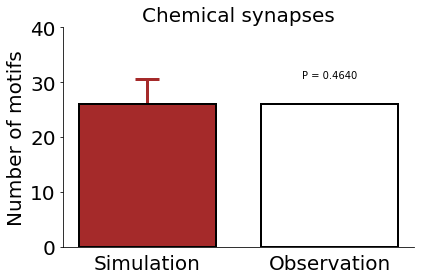

In [191]:
# This is our null hypothesis
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chem, n_found = mydataset.motif.ii_chem_found);
ax.set_title('Chemical synapses', size=20);
ax.set_ylim(ymax=40);
ax.tick_params(labelsize=20)

fig.savefig('ii_chem.pdf')

<H2>Plot electrical synapses alone </H2>

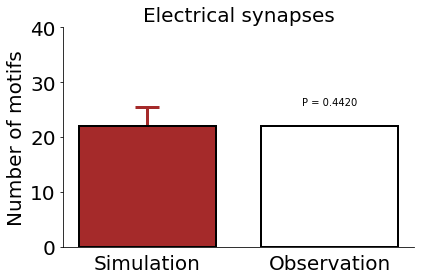

In [192]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_elec, n_found = mydataset.motif.ii_elec_found);
ax.set_title('Electrical synapses',  size=20);
ax.set_ylim(ymax=40);
ax.tick_params(labelsize=20)

fig.savefig('ii_elec.pdf')

<H2>Plot bidirectional chemical synapses</H2>


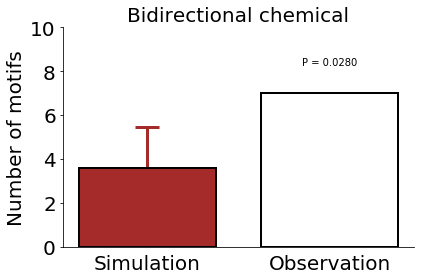

In [193]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2, n_found = mydataset.motif.ii_c2_found);
ax.set_title('Bidirectional chemical',  size=20);
ax.set_ylim(ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_c2.pdf')

<H2>Plot convergent inhibitory</H2>

0.187

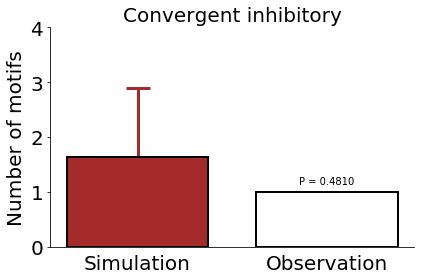

In [194]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_con, n_found = mydataset.motif.ii_con_found);
ax.set_title('Convergent inhibitory',  size=20);
ax.set_ylim(ymin=0, ymax=4);
ax.tick_params(labelsize=20)

fig.savefig('ii_con.pdf')

pii_con # change this value in the plot!

<H2> Plot divergent inhibitory </H2>

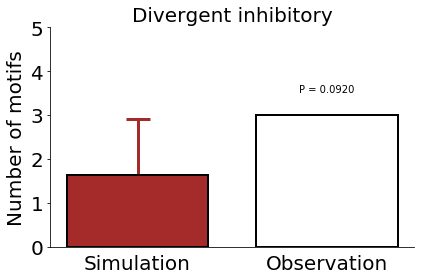

In [195]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_div, n_found = mydataset.motif.ii_div_found);
ax.set_title('Divergent inhibitory',  size=20);
ax.set_ylim(ymin=0, ymax=5);
ax.tick_params(labelsize=20)

fig.savefig('ii_c1e.pdf')

<H2>Plot linear chains</H2>

0.215

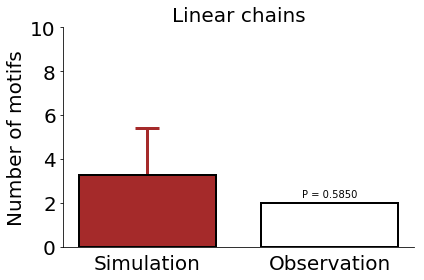

In [196]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chain, n_found = mydataset.motif.ii_chain_found);
ax.set_title('Linear chains',  size=20);
ax.set_ylim(ymin=0, ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_chain.pdf')

pii_chain # change this value in the plot!

<H2>Plot electrical and one chemical synapse alone </H2>

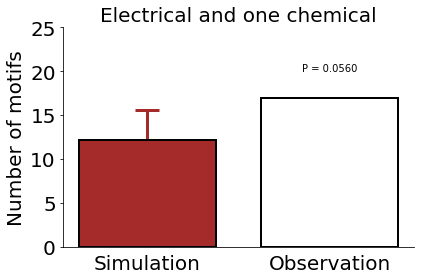

In [197]:
fig = figure() 
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c1e, n_found = mydataset.motif.ii_c1e_found);
ax.set_title('Electrical and one chemical',  size=20);
ax.set_ylim(ymax=25);
ax.tick_params(labelsize=20)

fig.savefig('ii_c1e.pdf')

<H2>Plot electrical and two chemical</H2>

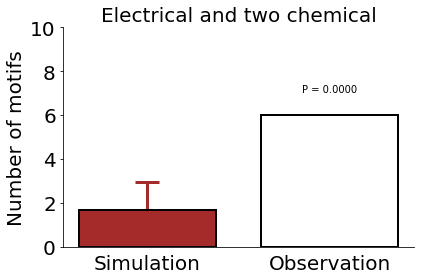

In [198]:
fig = figure(5)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2e, n_found = mydataset.motif.ii_c2e_found);
ax.set_title('Electrical and two chemical',  size=20);
ax.set_ylim(ymin  = 0, ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_c2d.pdf')